In [1]:
import yaml
from context import Dataset
from context import Predictor_CVM
from context import Predictor_sof, Predictor_zan, Predictor_kara
from context import Evaluator

['/home/rua7rng/code/the-atlas-benchmark/Trajectron-plus-plus/trajectron', '/home/rua7rng/code/the-atlas-benchmark/src', '/home/rua7rng/code/the-atlas-benchmark/demo', '/home/rua7rng/.vscode/extensions/ms-toolsai.jupyter-2022.2.1030672458/pythonFiles', '/home/rua7rng/.vscode/extensions/ms-toolsai.jupyter-2022.2.1030672458/pythonFiles/lib/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/rua7rng/code/the-atlas-benchmark/.venv/lib/python3.8/site-packages', '..', '..', '..', '..']


Create the dataset object based on the yaml file configuration

In [2]:
# Tested this instruction for the following datasets
# input_dataset = './cfg/dataset_config_hotel.yaml'
# input_dataset = '../cfg/dataset_config_eth.yaml'
# input_dataset = '../cfg/dataset_config_thor1.yaml'
input_dataset = '../cfg/dataset_config_thor3.yaml'
# input_dataset = '../cfg/dataset_config_atc.yaml'
# input_dataset = '../cfg/dataset_config_test_traj.yaml'
# input_dataset = '../cfg/dataset_config_test_point_obstacles.yaml'

with open(input_dataset, 'r') as file:
    benchmark_cfg = yaml.load(file, Loader=yaml.FullLoader)

# Optional split parameter defines the portion of the dataset that is being extracted,
# frames between 0 * length(dataset) and 1 * length(dataset)
dataset = Dataset(benchmark_cfg, split=[0,1])

Preparing a list of scenarios with valid observations and complete ground truth

In [3]:
observation_len = benchmark_cfg['benchmark']['setup']['observation period']
prediction_horizon = benchmark_cfg['benchmark']['setup']['prediction horizon']

# Here we iterate over all possible start frames in the dataset and extract the valid scenarios
# with sufficient observations for all detected pedestrians and the ground truth data
valid_scenes = dataset.extract_scenarios(prediction_horizon, observation_len, min_num_prople=2)

The thor3 dataset has 470 valid scenes with observation length 8 and prediction horizon 12 out of 2949 scenes total.


Initiating a predictor and calculating predictions for one scene. This time we consider only one aprticle without uncertainty.

In [4]:
with open('../cfg/method_config_kara.yaml', 'r') as file:
    method_cfg = yaml.load(file, Loader=yaml.FullLoader)

method_cfg['param']['uncertainty']['uncertainty'] = False
predictor_certain = Predictor_kara(dataset, method_cfg, ['optimal','eth'])
predictions = predictor_certain.predict(valid_scenes[100])

Now we can evaluate the predictions against the ground truth

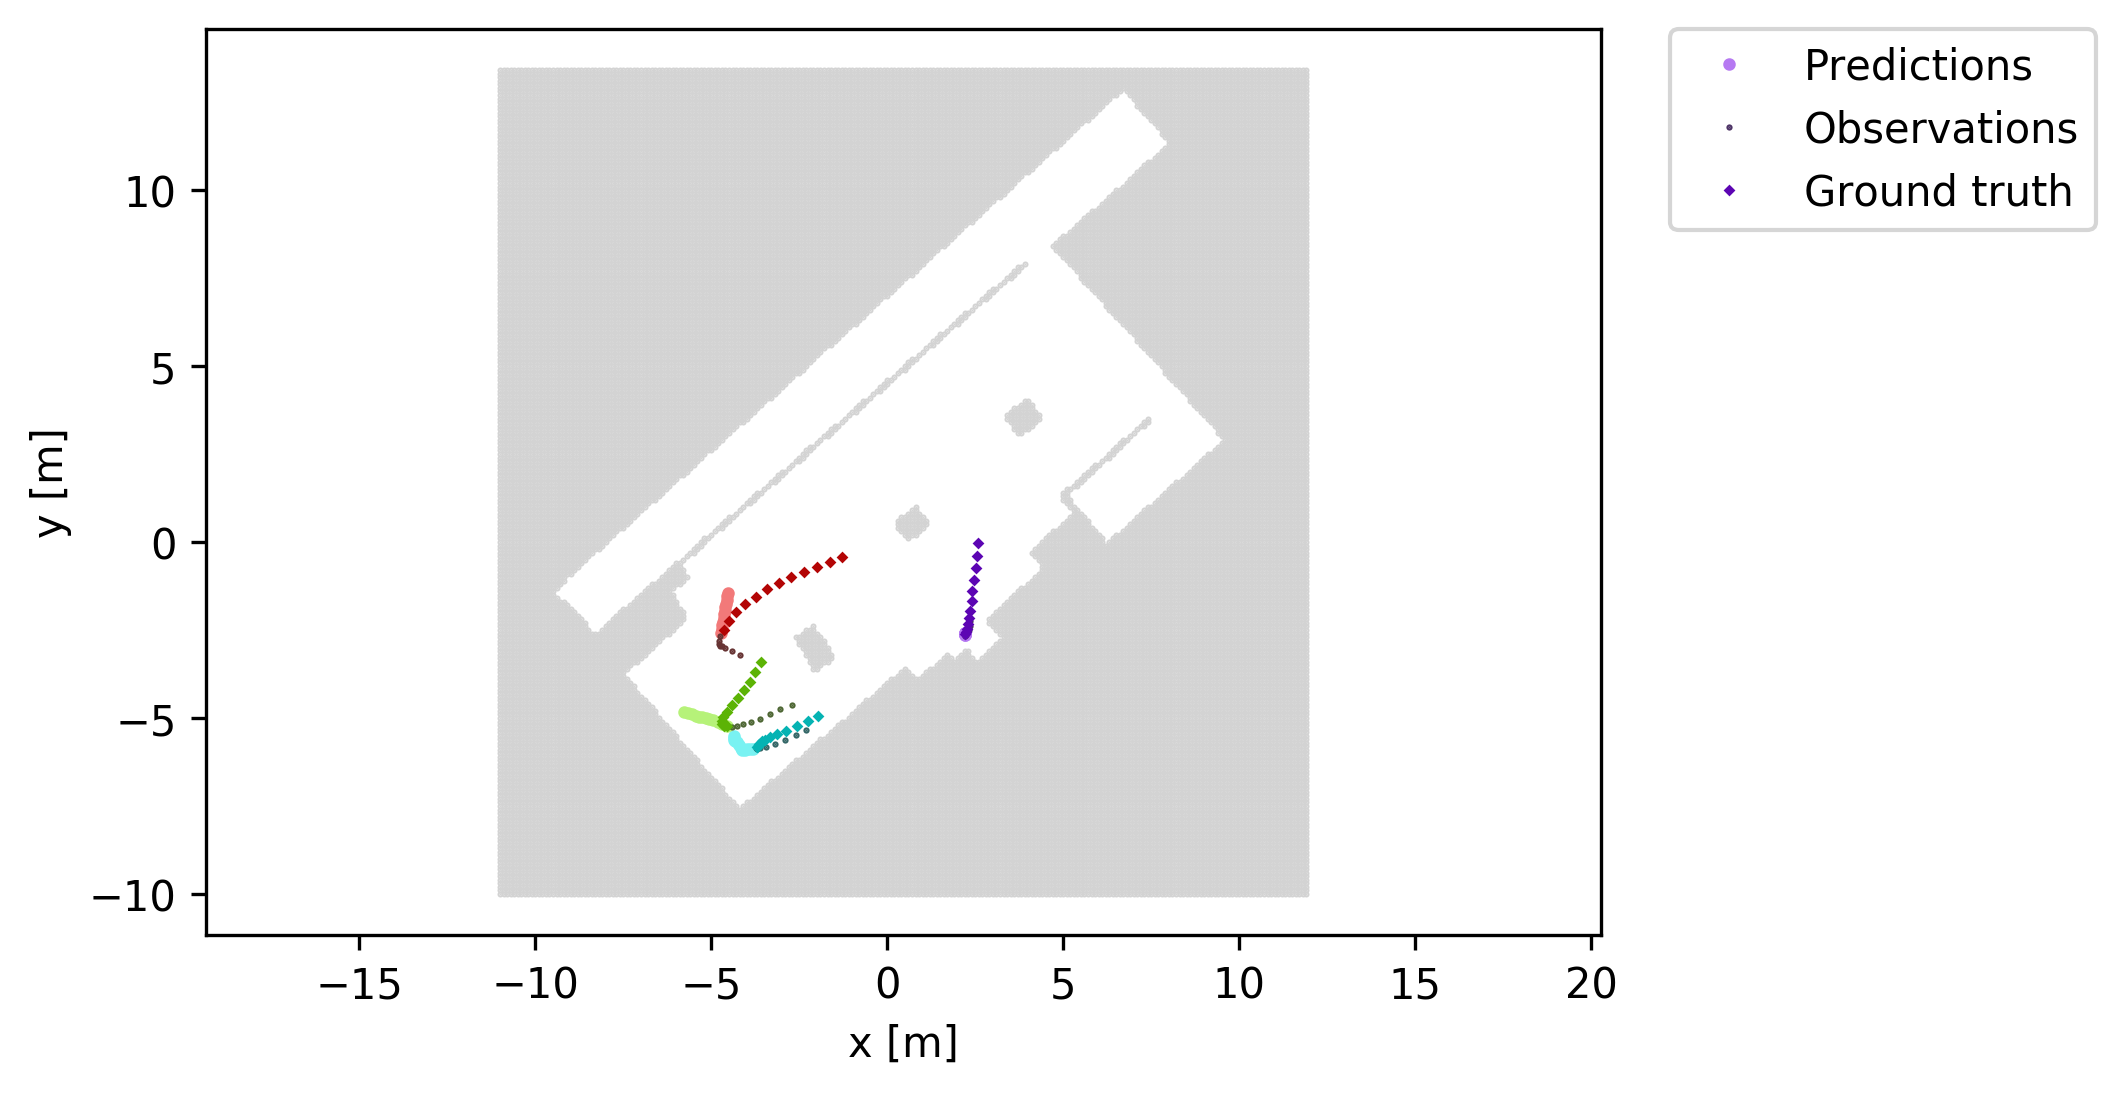

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

evaluation = Evaluator(set_GT_length=prediction_horizon)

#evaluation.evaluate_scenario_ade_fde(valid_scenes[19], predictions)
evaluation.plot_scenario(dataset, valid_scenes[100], predictions)

The same visualization for an uncertain predictor

The NLL of the final position prediction is 134.23043804738046


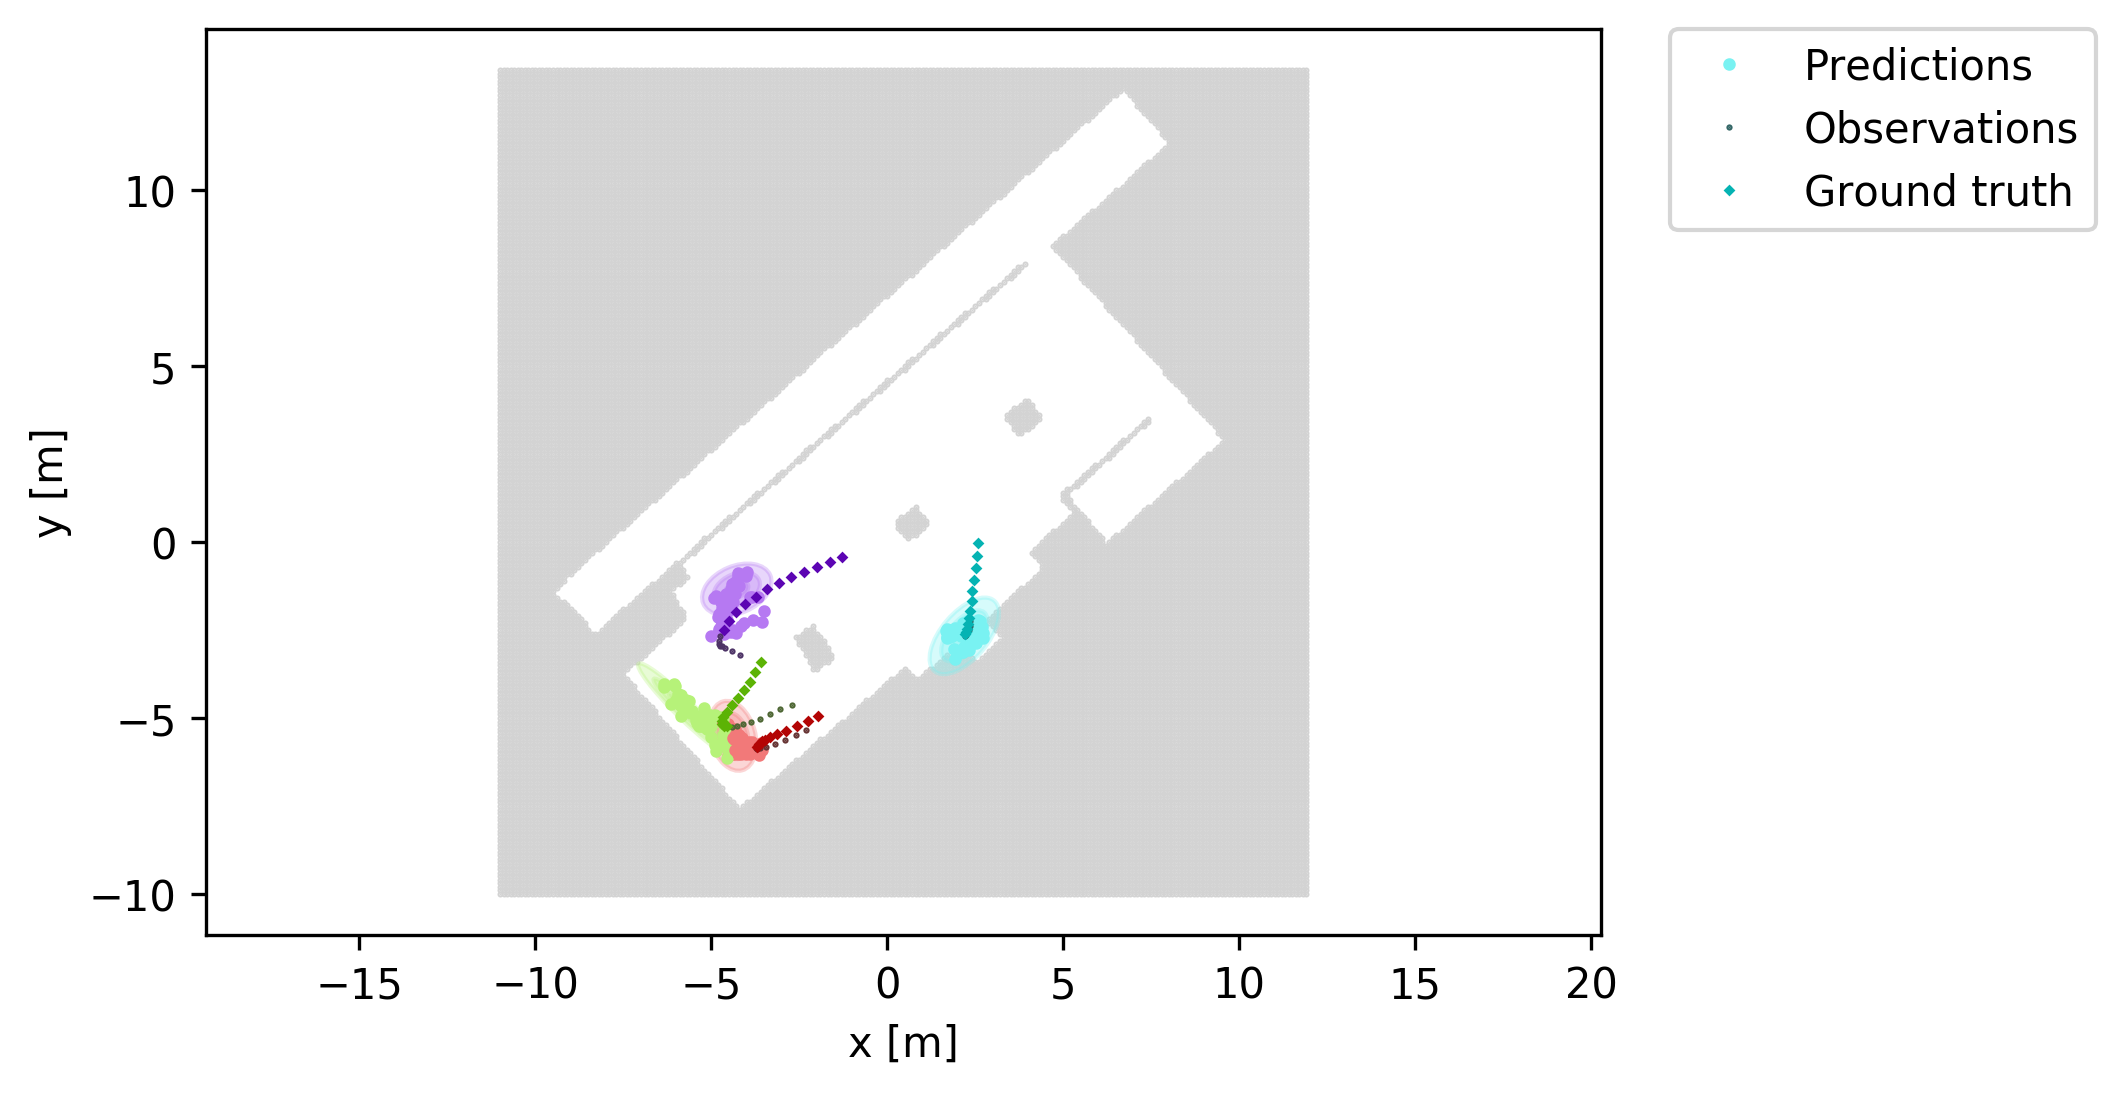

In [6]:
method_cfg['param']['uncertainty']['uncertainty'] = True
method_cfg['param']['uncertainty']['num_particles'] = 5
method_cfg['param']['uncertainty']['uncertainty sigma'] = 0.3
predictor_uncertain = Predictor_kara(dataset, method_cfg)
predictions = predictor_uncertain.predict(valid_scenes[100])

nll, _ = evaluation.cal_nll(valid_scenes[100],predictions)
print("The NLL of the final position prediction is", nll)
evaluation.plot_scenario(dataset, valid_scenes[100], predictions)

Making an animation

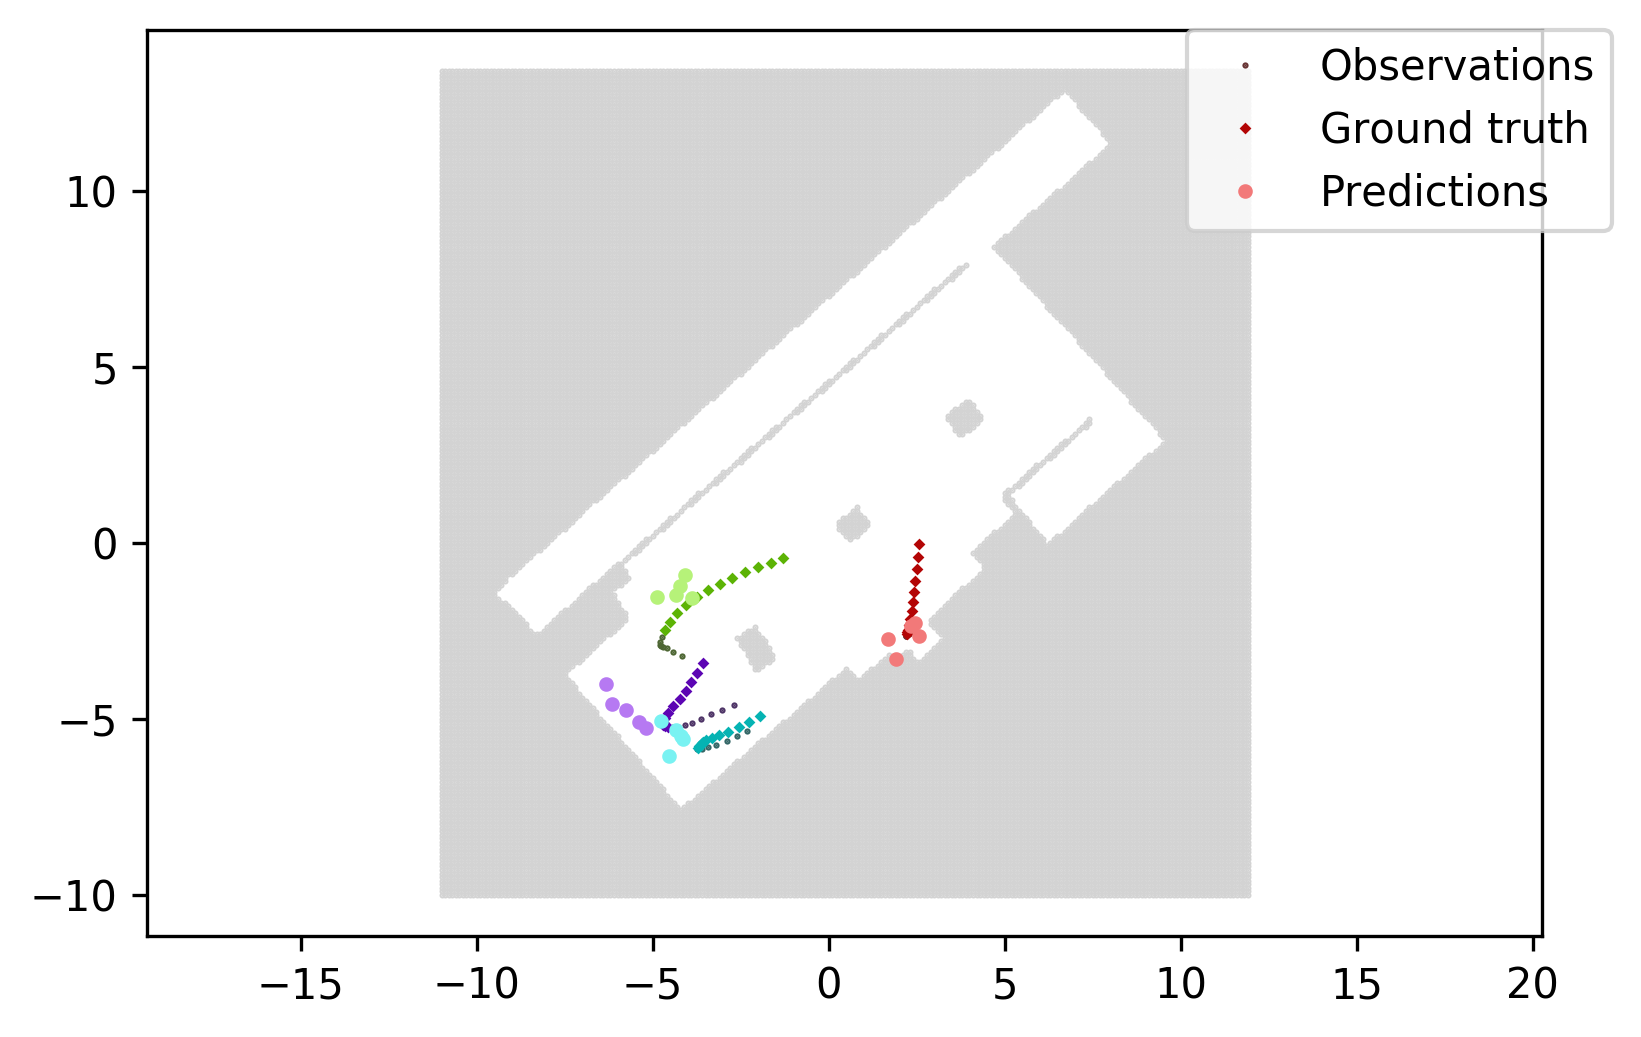

In [7]:
import pathlib
pathlib.Path('./gif').mkdir(parents=True, exist_ok=True)
ani = evaluation.draw_animation(dataset, valid_scenes[100], predictions)
ani.save('./gif/prediction_animation.gif', writer='imagemagick')

In [8]:
import numpy as np

results_ade = []
results_kade = []
for i in range(len(valid_scenes)):
    predictions = predictor_uncertain.predict(valid_scenes[i])
    metric_values_ade = evaluation.evaluate_scenario_ade_fde(valid_scenes[i],predictions)
    metric_values_kade = evaluation.evaluate_scenario_kade_kfde(valid_scenes[i],predictions)
    results_ade.append(metric_values_ade)
    results_kade.append(metric_values_kade)

print('The mean ADE is', np.mean([result[0] for result in results_ade]), '+-', np.std([result[0] for result in results_ade]))
print('The mean FDE is', np.mean([result[1] for result in results_ade]), '+-', np.std([result[1] for result in results_ade]))
print('The mean kADE is', np.mean([result[0] for result in results_kade]), '+-', np.std([result[0] for result in results_kade]))
print('The mean kFDE is', np.mean([result[1] for result in results_kade]), '+-', np.std([result[1] for result in results_kade]))

KeyboardInterrupt: 

Finally, here is an exmaple on using the NLL metric with undertain predictions

The NLL of the final position prediction with a low uncertinty value is 13.586210123872101


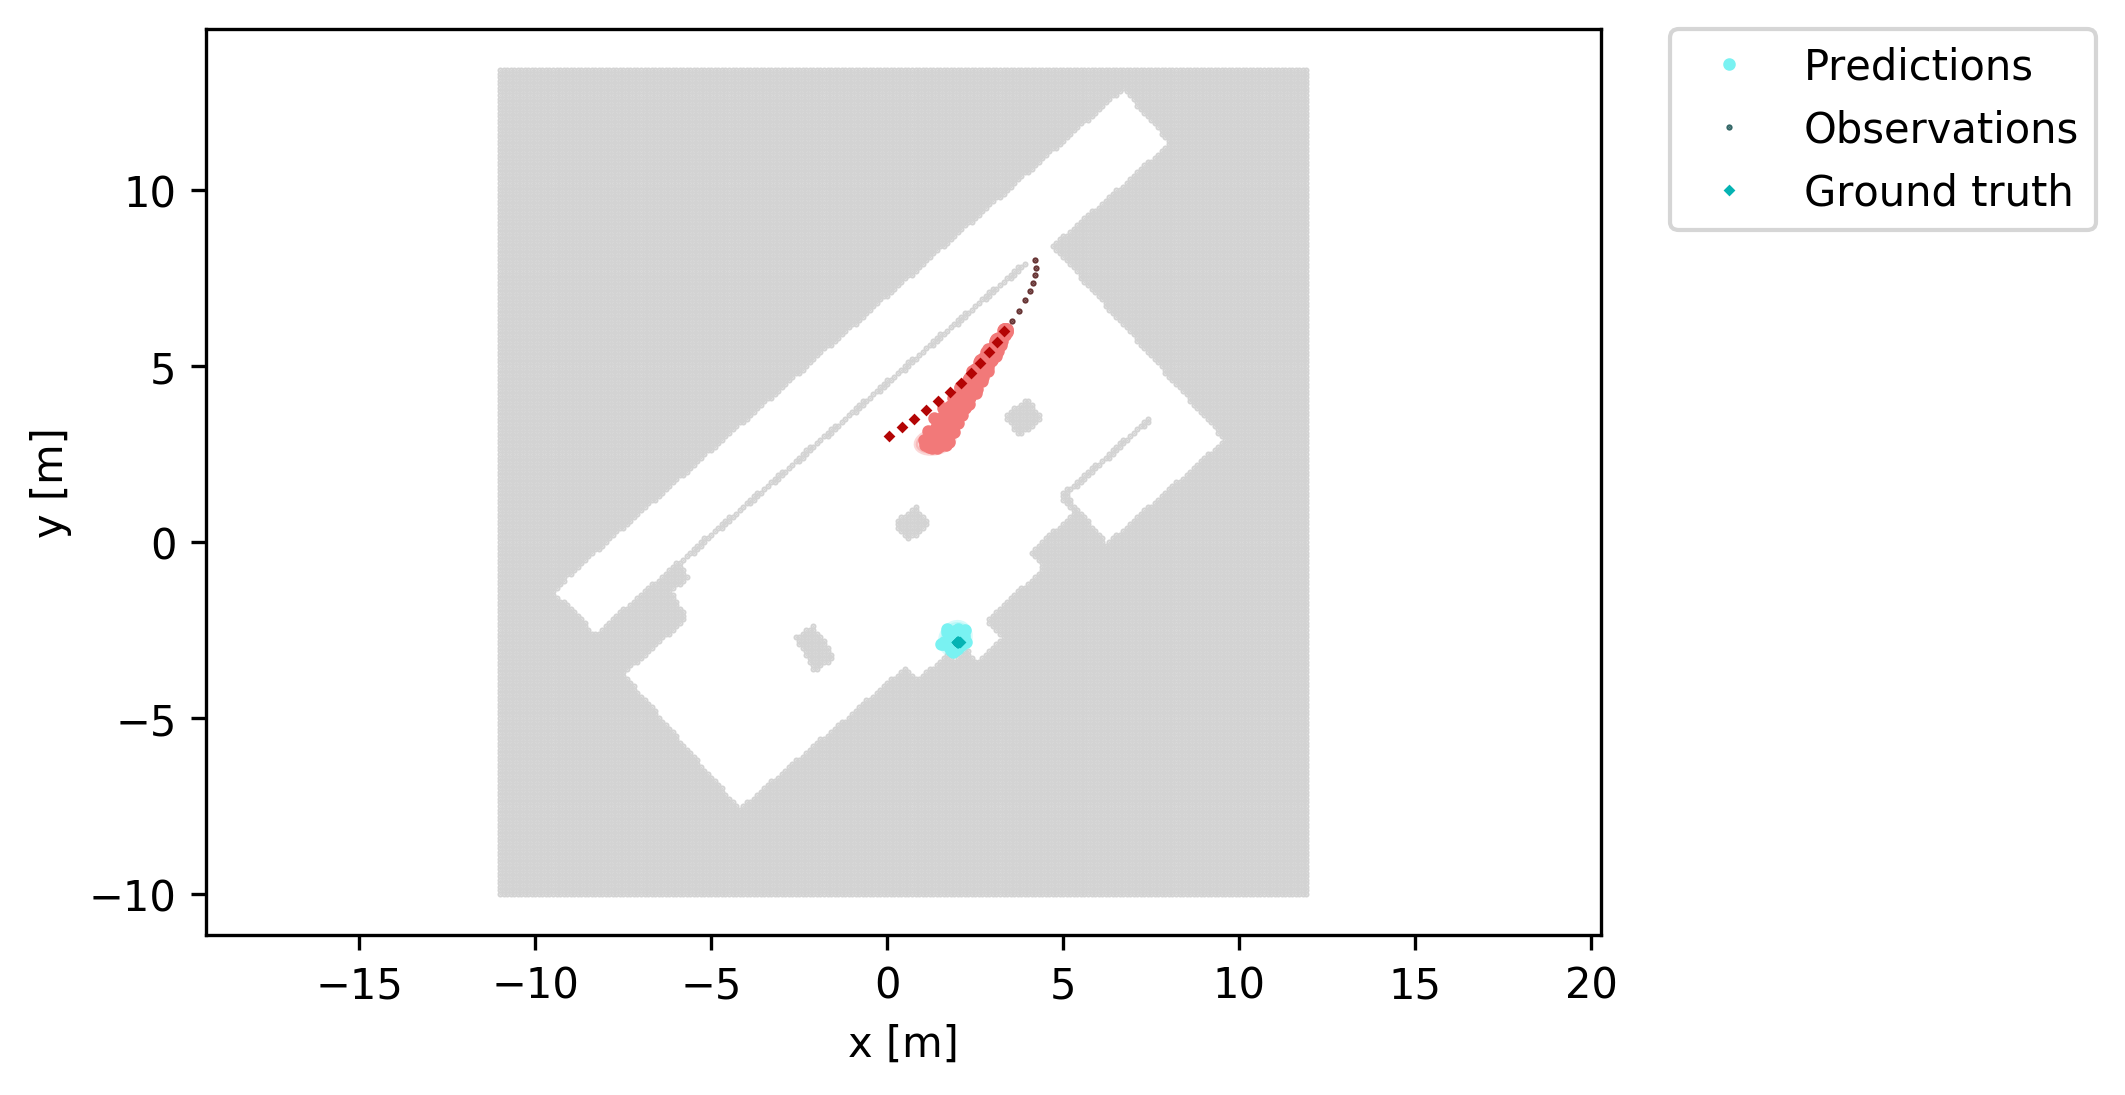

The NLL of the final position prediction with an average uncertinty value is 2.035075712109875


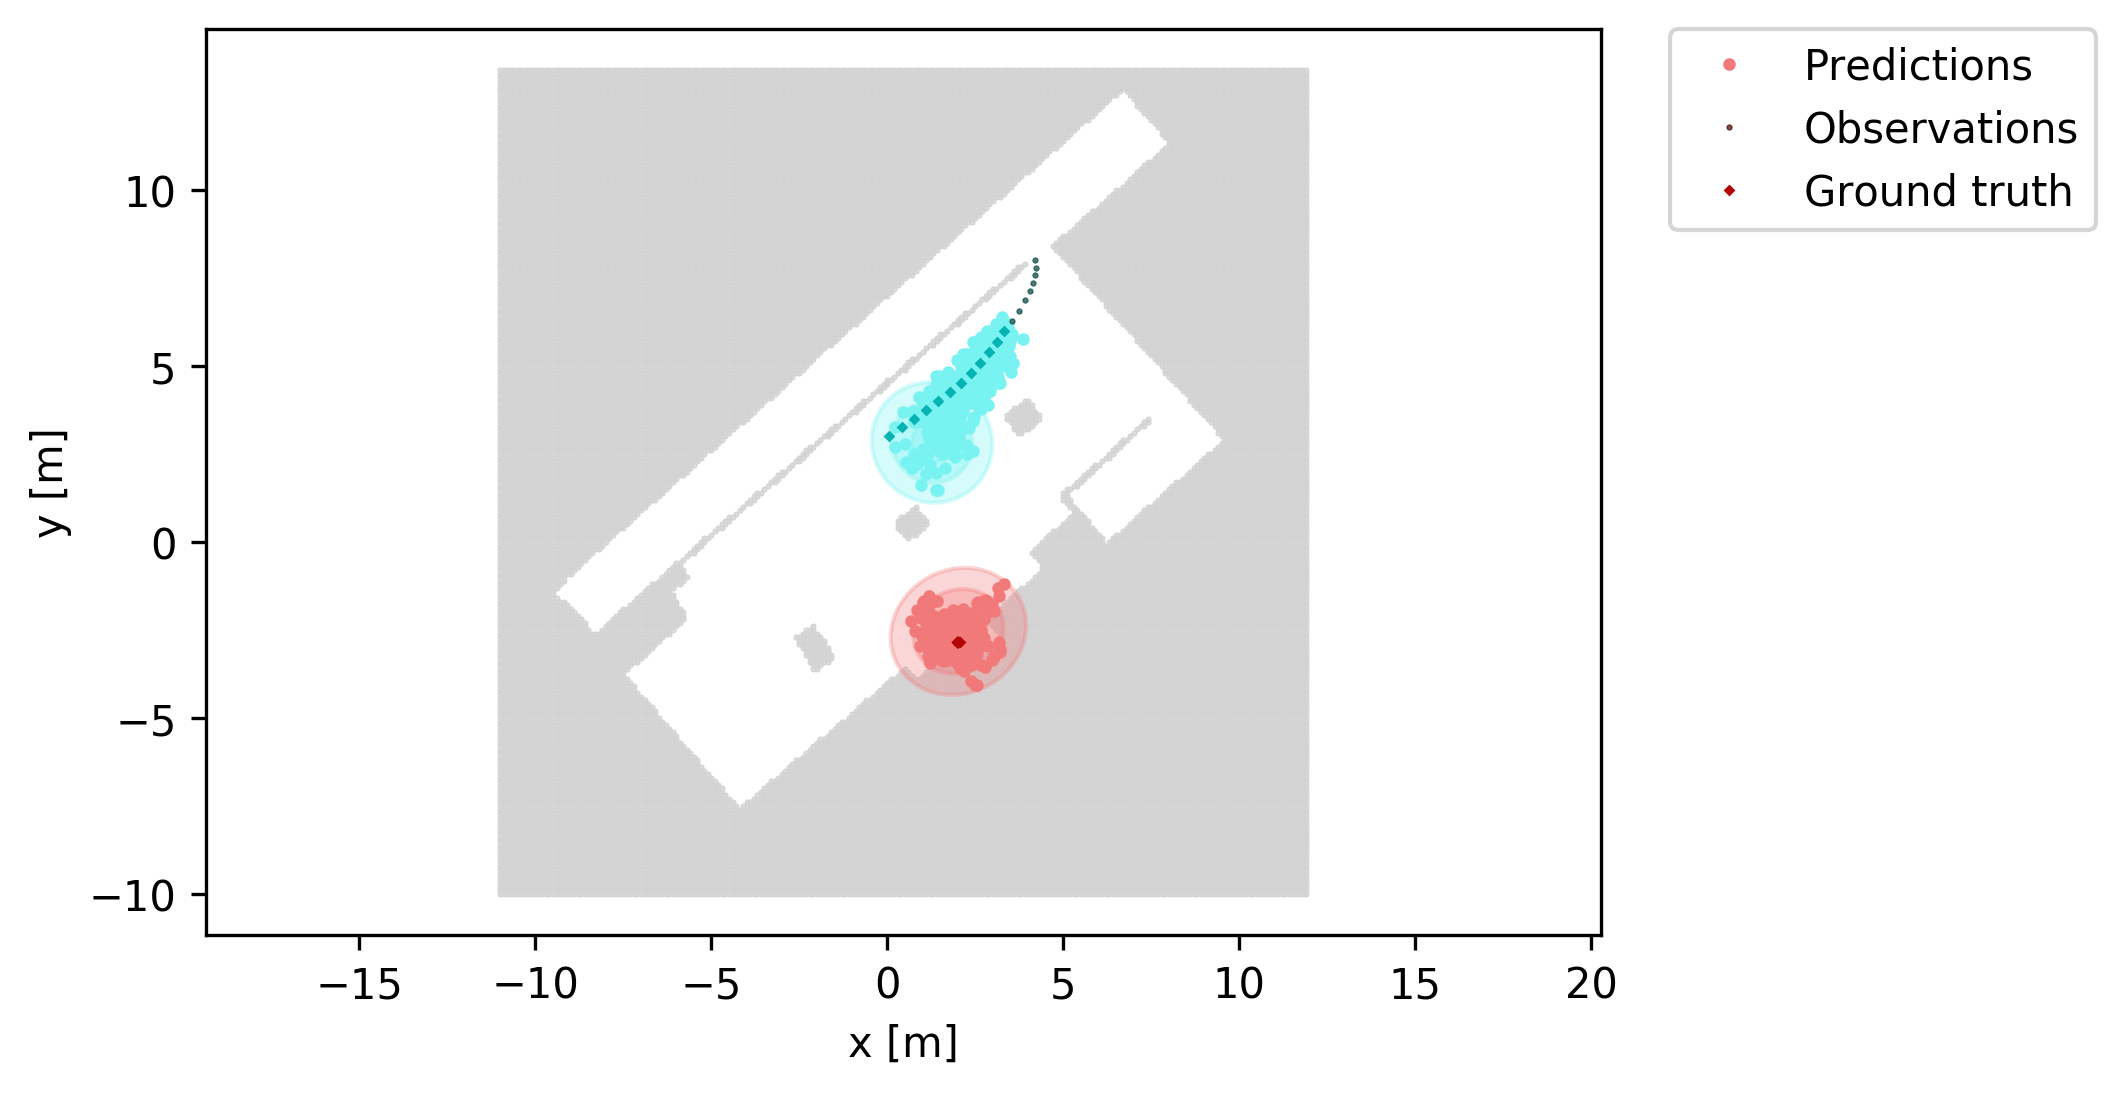

The NLL of the final position prediction with a high uncertinty value is 3.237600111670143


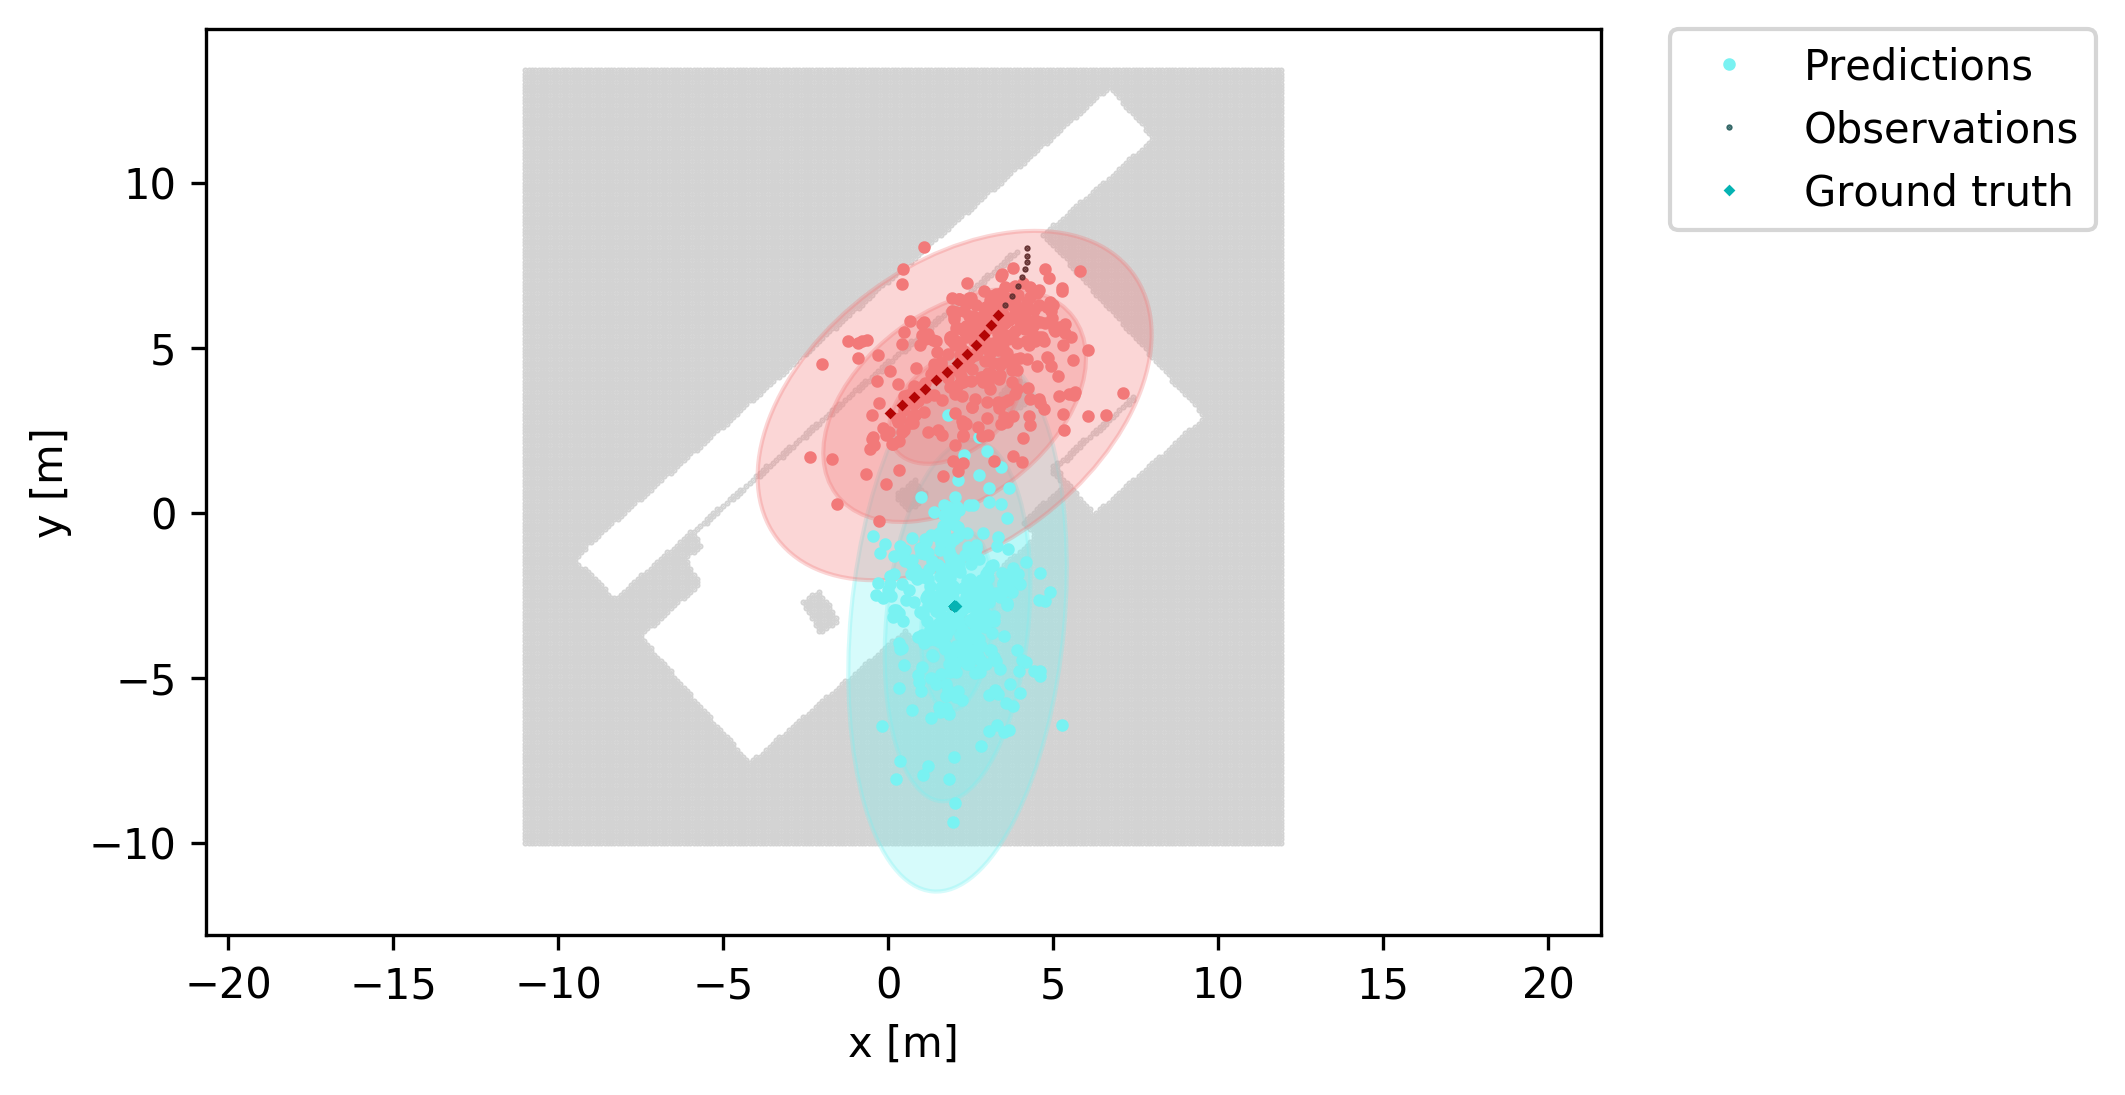

In [9]:
method_cfg['param']['uncertainty']['uncertainty'] = True
method_cfg['param']['uncertainty']['num_particles'] = 30

method_cfg['param']['uncertainty']['uncertainty sigma'] = 0.1
predictor_uncertain_low = Predictor_kara(dataset, method_cfg)

method_cfg['param']['uncertainty']['uncertainty sigma'] = 0.5
predictor_uncertain_avg = Predictor_kara(dataset, method_cfg)

method_cfg['param']['uncertainty']['uncertainty sigma'] = 1.5
predictor_uncertain_high = Predictor_kara(dataset, method_cfg)

scene_id = 0

nll_results = []
for _ in range(10):
    predictions = predictor_uncertain_low.predict(valid_scenes[scene_id])
    nll, _ = evaluation.cal_nll(valid_scenes[scene_id], predictions)
    nll_results.append(nll)
print("The NLL of the final position prediction with a low uncertinty value is", np.mean(nll))

evaluation.plot_scenario(dataset, valid_scenes[scene_id], predictions)

nll_results = []
for _ in range(10):
    predictions = predictor_uncertain_avg.predict(valid_scenes[scene_id])
    nll, _ = evaluation.cal_nll(valid_scenes[scene_id], predictions)
    nll_results.append(nll)
print("The NLL of the final position prediction with an average uncertinty value is", np.mean(nll))

evaluation.plot_scenario(dataset, valid_scenes[scene_id], predictions)

nll_results = []
for _ in range(10):
    predictions = predictor_uncertain_high.predict(valid_scenes[scene_id])
    nll, _ = evaluation.cal_nll(valid_scenes[scene_id], predictions)
    nll_results.append(nll)
print("The NLL of the final position prediction with a high uncertinty value is", np.mean(nll))

evaluation.plot_scenario(dataset, valid_scenes[scene_id], predictions)

